# Проект для «Викишоп»

Заказчик - Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные.

Для выполнения проекта применять *BERT* необязательно, но можно попробовать.

# План работ

1. Загрузите и подготовьте данные.
 * 1.2. Лемматизируем и очистим текст.
2. Обучите разные модели. 
3. Сделайте выводы.

# Описание данных

Данные находятся в файле `toxic_comments.csv`. 

*text* — содержит текст комментария

*toxic* — целевой признак.

## Подготовка данных и загрузка библиотек

In [1]:
!pip install catboost
!pip install pytorch-transformers

     |████████████████████████████████| 176 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 135 kB 11.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 62.0 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 1.6 MB/s  eta 0:00:01
     |████████████████████████████████| 10.5 MB 18.4 MB/s eta 0:00:01


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import io
import torch
import time 
import warnings

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score,make_scorer,accuracy_score,roc_auc_score,roc_curve
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC, LinearSVC
from catboost import Pool, CatBoostClassifier
from tqdm import notebook,tqdm, trange

from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

#nltk.download('wordnet','stopwords','punkt','averaged_perceptron_tagger')

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.dummy import DummyClassifier

from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec
from pytorch_transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification
from IPython.display import clear_output

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

In [3]:
warnings.filterwarnings('ignore')
nltk.download('stopwords')
tqdm.pandas()

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
comment = pd.read_csv('toxic_comments.csv')

In [5]:
print(comment.head(5))

   Unnamed: 0                                               text  toxic
0           0  Explanation\nWhy the edits made under my usern...      0
1           1  D'aww! He matches this background colour I'm s...      0
2           2  Hey man, I'm really not trying to edit war. It...      0
3           3  "\nMore\nI can't make any real suggestions on ...      0
4           4  You, sir, are my hero. Any chance you remember...      0


In [6]:
comment.toxic.value_counts()/comment.shape[0]*100

0    89.838787
1    10.161213
Name: toxic, dtype: float64

In [7]:
def df_info(df):
    df.info()
    print(80*"+")
    print(f'количество пропусков по столбцам:')
    for i,j in enumerate(df.columns):
        print(j,'=',df.iloc[:,i].isna().sum())
    print('Описание количественных переменных:')
    print(df.describe(percentiles=[.25,.5]))
    print(80*"+")
    print(f'количество дубликатов в таблице = {df.duplicated().sum()}')

In [8]:
df_info(comment)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
количество пропусков по столбцам:
Unnamed: 0 = 0
text = 0
toxic = 0
Описание количественных переменных:
          Unnamed: 0          toxic
count  159292.000000  159292.000000
mean    79725.697242       0.101612
std     46028.837471       0.302139
min         0.000000       0.000000
25%     39872.750000       0.000000
50%     79721.500000       0.000000
max    159450.000000       1.000000
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
количество дубликатов в таблице = 0


In [9]:
# comment_new = []
# pattern = r'[^a-zA-Z0-9]' 
# for sentence in comment.text:
#    cleared_text = re.sub(pattern, " ", sentence)
#    comment_new.append(" ". join(cleared_text.split()))

In [10]:
# comment['text'] = comment_new
# comment.head()

# 1.2 Лемматизируем и очистим текст

In [11]:
corpus = comment['text'].values

In [12]:
def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Z]', ' ', text).split())

In [13]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [14]:
n = WordNetLemmatizer()

def lemmafunct(text):
    m =[]
    for i in nltk.word_tokenize(text):
        m.append(n.lemmatize(i, get_wordnet_pos(i)))
    return ' '.join(m)

In [15]:
# nltk.download("stopwords")

In [16]:
%%time

lemy = []
for i in tqdm(range(len(corpus))):
    lemy.append(lemmafunct(clear_text(corpus[i])))
    
comment['text'] = pd.Series(lemy, index = comment.index)

100%|██████████| 159292/159292 [27:19<00:00, 97.17it/s] 


CPU times: user 23min 28s, sys: 2min 14s, total: 25min 42s
Wall time: 27min 19s


In [17]:
display(comment.shape)

(159292, 3)

In [18]:
display(comment.sample(n=5, random_state=1)) 

,Unnamed: 0,text,toxic
153427,153584,bite me that be all cunt,1
32336,32376,Actually im certain this will be the last brea...,0
38658,38704,I protest not for the sake of argue but for th...,0
37972,38018,It also just now occurs to me I didn t mention...,0
71966,72036,Keep There s an entire category for US weekday...,0


In [11]:
features = comment['text']
target = comment['toxic']

In [12]:
display(features.shape)
display(target.shape)

(159292,)

(159292,)

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size = 0.4, random_state = 12345)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size = 0.5, random_state = 12345)

In [14]:
# display(X_train)

In [15]:
display(X_train.shape)
display(X_valid.shape)
display(X_test.shape)

(95575,)

(31858,)

(31859,)

In [16]:
count_tf_idf = TfidfVectorizer(analyzer = 'word', stop_words= 'english')

X_train = count_tf_idf.fit_transform(X_train)
X_valid = count_tf_idf.transform(X_valid)
X_test = count_tf_idf.transform(X_test)

display('*'*60)
display('Обучающая выборка')
display(X_train.shape)
display('*'*60)
display('Валидационная выборка')
display(X_valid.shape)
display('*'*60)
display('Тестовая выборка')
display(X_test.shape)
display('*'*60)

'************************************************************'

'Обучающая выборка'

(95575, 138178)

'************************************************************'

'Валидационная выборка'

(31858, 138178)

'************************************************************'

'Тестовая выборка'

(31859, 138178)

'************************************************************'

## Обучение

**Модель Логистическая регрессия**

In [25]:
%%time

model = LogisticRegression(random_state = 12345, solver='sag', max_iter = 14, C=9)
model.fit(X_train, y_train)
predict = model.predict(X_valid)
f1 = f1_score(y_valid, predict)
display('Модель LogisticRegression качество f1 равно', f1)

'Модель LogisticRegression качество f1 равно'

0.7705169766251494

CPU times: user 1.5 s, sys: 6.34 ms, total: 1.51 s
Wall time: 1.54 s


**Модель Дерево решений**

In [26]:
%%time

for depth in range(24, 28):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(X_train, y_train)
    predict = model.predict(X_valid)
    f1 = f1_score(y_valid, predict)
    display(f'Модель Дерево решений (глубина {depth}) качество f1 равно {f1}')

'Модель Дерево решений (глубина 24) качество f1 равно 0.659606656580938'

'Модель Дерево решений (глубина 25) качество f1 равно 0.6647897897897899'

'Модель Дерево решений (глубина 26) качество f1 равно 0.6684151367553391'

'Модель Дерево решений (глубина 27) качество f1 равно 0.6691533010070868'

CPU times: user 41.5 s, sys: 186 ms, total: 41.7 s
Wall time: 41.8 s


**Модель Случайный лес**

In [27]:
%%time

for n_est in (20, 30, 40):
    model = RandomForestClassifier(random_state = 12345, n_estimators = n_est)
    model.fit(X_train, y_train)
    predict = model.predict(X_valid)
    f1 = f1_score(y_valid, predict)
    display(f'Модель Случайный лес ({n_est} деревьев) качество f1 равно {f1}')

'Модель Случайный лес (20 деревьев) качество f1 равно 0.697254606995111'

'Модель Случайный лес (30 деревьев) качество f1 равно 0.7057941121320083'

'Модель Случайный лес (40 деревьев) качество f1 равно 0.7092675635276533'

CPU times: user 5min 51s, sys: 1.1 s, total: 5min 52s
Wall time: 5min 55s


**Модель Градиентный бустинг CatBoost**

In [28]:
%%time

for n_est in (20, 30, 40):
    model = CatBoostClassifier(verbose=False, n_estimators = n_est)
    model.fit(X_train, y_train)
    predict = model.predict(X_valid)
    f1 = f1_score(y_valid, predict)
    display(f'CatBoost ({n_est} деревьев) качество f1 равно {f1}')

'CatBoost (20 деревьев) качество f1 равно 0.6674356016916572'

'CatBoost (30 деревьев) качество f1 равно 0.6900958466453675'

'CatBoost (40 деревьев) качество f1 равно 0.7082027649769586'

CPU times: user 4min 25s, sys: 4 s, total: 4min 29s
Wall time: 4min 33s


**Проводим тестирование лучшей модели на тестовой выборке**

'F1 лучшей модели на тестовой выборке равно 0.765'

'AUC-ROC лучшей модели на тестовой выборке равно 0.964'

<Figure size 432x288 with 0 Axes>

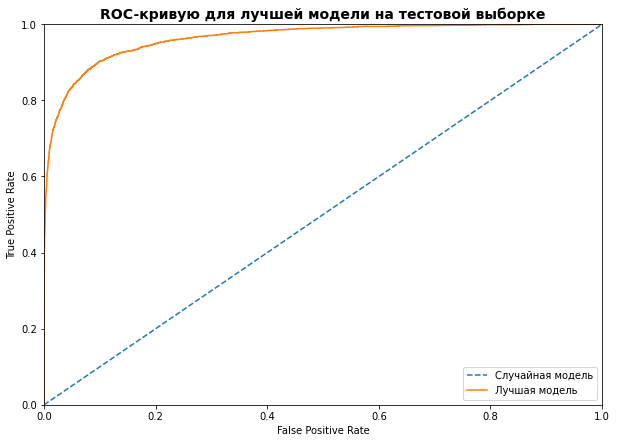

In [29]:
model = LogisticRegression(random_state = 12345, solver='sag', max_iter = 14, C=9)
model.fit(X_train, y_train)
predictions_test = model.predict(X_test) 
f1 = f1_score(y_test, predictions_test) 

display ('F1 лучшей модели на тестовой выборке равно {0:.3f}'.format(f1)) 

probabilities_test = model.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
auc_roc = roc_auc_score(y_test, probabilities_one_test)

display ('AUC-ROC лучшей модели на тестовой выборке равно {0:.3f}'.format(auc_roc)) 

plt.figure()

plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.plot(fpr, tpr)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривую для лучшей модели на тестовой выборке', fontsize=14, fontweight="bold")
plt.legend(('Случайная модель','Лучшая модель'), loc= 'lower right'); 

## Итоги:

Среди обученных моделей я выявил что лучший результат показала модель Логистическая регрессия.

По качеству лучшая модель достигла необходимый по условию проекта - заказчика уровень метрики f1 не ниже 0,75 на валидационной и на тестовой выборках.

f1 лучшей модели на валидационной выборкес 0.77

f1 лучшей модели на тестовой выборке 0.765